Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import datetime
import time
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from sklearn.model_selection import train_test_split
import sklearn
from IPython.display import display
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# **Generating Dataset** ⭐

In [ ]:
def generate_customer_profiles_table(n_customers, random_state=0):
    """
    Genera una tabla de perfiles de clientes con propiedades aleatorias.
    
    Args:
    n_customers (int): Número de clientes a generar.
    random_state (int): Estado inicial del generador de números aleatorios para reproducibilidad.

    Returns:
    DataFrame: Tabla con los perfiles de clientes incluyendo 'CUSTOMER_ID', 'mean_amount', 
               'std_amount' y 'mean_nb_tx_per_day'.
    """
    np.random.seed(random_state)

    customer_id_properties=[]

    for customer_id in range(n_customers):

        mean_amount = np.random.uniform(5,100)
        std_amount = mean_amount/2

        mean_nb_tx_per_day = np.random.uniform(1,5)

        customer_id_properties.append([customer_id,
                                      mean_amount, std_amount,
                                      mean_nb_tx_per_day])

    customer_profiles_table = pd.DataFrame(customer_id_properties, columns=['CUSTOMER_ID',
                                                                      'mean_amount', 'std_amount',
                                                                      'mean_nb_tx_per_day'])

    return customer_profiles_table

In [ ]:
# Ejemplo
n_customers = 5
customer_profiles_table = generate_customer_profiles_table(n_customers)
customer_profiles_table

,CUSTOMER_ID,mean_amount,std_amount,mean_nb_tx_per_day
0,0,57.137283,28.568641,5.721515
1,1,62.262521,31.131260,4.359065
2,2,45.247206,22.623603,5.167153
3,3,46.570785,23.285393,7.134184
4,4,96.547962,48.273981,3.067532


In [ ]:
def generate_web_profiles_table(n_webs, random_state=0):
    """
    Genera una tabla de perfiles de sitios web con categorías asignadas aleatoriamente.

    Args:
    n_webs (int): Número de sitios web a generar.
    random_state (int): Estado inicial del generador de números aleatorios para reproducibilidad.

    Returns:
    DataFrame: Tabla con los perfiles de sitios web incluyendo 'WEB_ID', 'type', y 'type_encoded'.
    """
    np.random.seed(random_state)

    web_id_properties=[]

    for web_id in range(n_webs):

        porcentajes = {
            'Computer and consumer electronics': 21.2,
            'Apparel and accessories': 19.7,
            'Furniture and home furnishings': 12.5,
            'Health and personal care and beauty': 10.7,
            'Auto and parts': 8.3,
            'Food and beverage': 7.6,
            'Toys and hobby': 7.2,
            'Books/music/video': 5.2,
            'Office equipment and supplies': 1.9,
            'Other': 5.6
        }

        category = random.choices(list(porcentajes.keys()), weights=list(porcentajes.values()))[0]

        type_encoded = list(porcentajes.keys()).index(category)

        web_id_properties.append([web_id, category, type_encoded])

    web_profiles_table = pd.DataFrame(web_id_properties, columns=['WEB_ID', 'type', 'type_encoded'])

    return web_profiles_table

In [ ]:
# Ejemplo
web_profiles_table = generate_web_profiles_table(5)
web_profiles_table

,WEB_ID,type,type_encoded
0,0,Computer and consumer electronics,0
1,1,Toys and hobby,6
2,2,Furniture and home furnishings,2
3,3,Apparel and accessories,1
4,4,Apparel and accessories,1


In [ ]:
def generate_fraud_transaction():
    """
    Genera un monto de transacción para un caso de fraude.

    Returns:
    float: Monto de la transacción generada.
    """
    random_mu = np.random.randint(50)
    random_sigma = 10
    transaction = np.random.normal(loc=random_mu, scale=random_sigma)
    return np.round(np.abs(transaction),2)

In [ ]:
def generate_transactions_table(customer_profile, web_id_mapping, start_date = "2023-01-01", nb_days = 10):
    """
    Genera una tabla de transacciones para un perfil de cliente dado y un mapeo de identificadores web.

    Args:
    customer_profile (DataFrame): Perfil del cliente.
    web_id_mapping (dict): Mapeo de identificadores web a categorías.
    start_date (str): Fecha de inicio de las transacciones. Por defecto: "2023-01-01".
    nb_days (int): Número de días para generar transacciones. Por defecto: 10.

    Returns:
    DataFrame: Tabla de transacciones generadas.
    """
    customer_transactions = []

    random.seed(int(customer_profile.CUSTOMER_ID))
    np.random.seed(int(customer_profile.CUSTOMER_ID))

    for day in range(nb_days):

        nb_tx = np.random.poisson(customer_profile.mean_nb_tx_per_day)

        if nb_tx>0:

            for tx in range(nb_tx):

                # Time of transaction: Around noon, std 20000 seconds. This choice aims at simulating the fact that
                # most transactions occur during the day.
                time_tx = int(np.random.normal(86400/2, 20000))

                # If transaction time between 0 and 86400, let us keep it, otherwise, let us discard it
                if (time_tx>0) and (time_tx<86400):

                    # Amount is drawn from a normal distribution
                    amount = np.random.normal(customer_profile.mean_amount, customer_profile.std_amount)

                    # If amount negative, draw from a uniform distribution
                    if amount<0:
                        amount = np.random.uniform(0,customer_profile.mean_amount*2)

                    amount=np.round(amount,decimals=2)

                    web_id, category = random.choice(list(web_id_mapping.items()))

                    customer_transactions.append([time_tx+day*86400, day,
                                                      customer_profile.CUSTOMER_ID,
                                                      web_id, category, amount])

    customer_transactions = pd.DataFrame(customer_transactions, columns=['TX_TIME_SECONDS', 'TX_TIME_DAYS', 'CUSTOMER_ID', 'WEB_ID', 'CATEGORY', 'TX_AMOUNT'])

    if len(customer_transactions)>0:
        customer_transactions['TX_DATETIME'] = pd.to_datetime(customer_transactions["TX_TIME_SECONDS"], unit='s', origin=start_date)
        customer_transactions=customer_transactions[['TX_DATETIME','CUSTOMER_ID', 'WEB_ID', 'CATEGORY', 'TX_AMOUNT','TX_TIME_SECONDS', 'TX_TIME_DAYS']]

    # print(customer_profile.CUSTOMER_ID)

    return customer_transactions

In [ ]:
def generate_dataset(n_customers = 10000, n_webs = 100, nb_days=90, start_date="2023-01-01"):
    """
    Genera un conjunto de datos simulados que incluye perfiles de clientes, perfiles de sitios web y transacciones.

    Args:
    n_customers (int): Número de clientes a generar. Por defecto: 10000.
    n_webs (int): Número de sitios web a generar. Por defecto: 100.
    nb_days (int): Número de días para generar transacciones. Por defecto: 90.
    start_date (str): Fecha de inicio de las transacciones. Por defecto: "2023-01-01".

    Returns:
    tuple: Una tupla que contiene las tablas de perfiles de clientes y sitios web, y la tabla de transacciones generadas.
    """
    start_time=time.time()
    customer_profiles_table = generate_customer_profiles_table(n_customers, random_state = 0)
    print("Time to generate customer profiles table: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    web_profiles_table = generate_web_profiles_table(n_webs, random_state = 1)
    web_id_mapping = dict(zip(web_profiles_table['WEB_ID'], web_profiles_table['type_encoded']))
    print("Time to generate web profiles table: {0:.2}s".format(time.time()-start_time))

    start_time=time.time()
    transactions_df=customer_profiles_table.groupby('CUSTOMER_ID').apply(lambda x : generate_transactions_table(x.iloc[0], web_id_mapping, nb_days=nb_days)).reset_index(drop=True)

    print("Time to generate transactions: {0:.2}s".format(time.time()-start_time))

    # Sort transactions chronologically
    transactions_df=transactions_df.sort_values('TX_DATETIME')
    # Reset indices, starting from 0
    transactions_df.reset_index(inplace=True,drop=True)
    transactions_df.reset_index(inplace=True)
    # TRANSACTION_ID are the dataframe indices, starting from 0
    transactions_df.rename(columns = {'index':'TRANSACTION_ID'}, inplace = True)

    return (customer_profiles_table, web_profiles_table, transactions_df)

In [ ]:
# Generación de la BD
(customer_profiles_table, web_profiles_table, transactions_df)= generate_dataset(n_customers = 3000,
                                                                                      n_webs = 100,
                                                                                      nb_days = 300,
                                                                                      start_date="2023-01-01")

Time to generate customer profiles table: 0.032s
Time to generate web profiles table: 0.014s
Time to generate transactions: 1.5e+02s


In [ ]:
transactions_df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,WEB_ID,CATEGORY,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS
0,0,2023-01-01 00:00:11,1211.0,89,4,44.14,11,0
1,1,2023-01-01 00:00:30,356.0,83,2,75.92,30,0
2,2,2023-01-01 00:02:51,475.0,8,1,26.04,171,0
3,3,2023-01-01 00:03:12,53.0,27,2,51.89,192,0
4,4,2023-01-01 00:07:56,2.0,7,7,82.36,476,0
...,...,...,...,...,...,...,...,...
2605612,2605612,2023-10-27 23:56:04,2554.0,3,0,79.27,25919764,299
2605613,2605613,2023-10-27 23:57:58,767.0,12,0,66.76,25919878,299
2605614,2605614,2023-10-27 23:58:37,2180.0,57,3,27.52,25919917,299
2605615,2605615,2023-10-27 23:59:13,2695.0,39,0,86.43,25919953,299


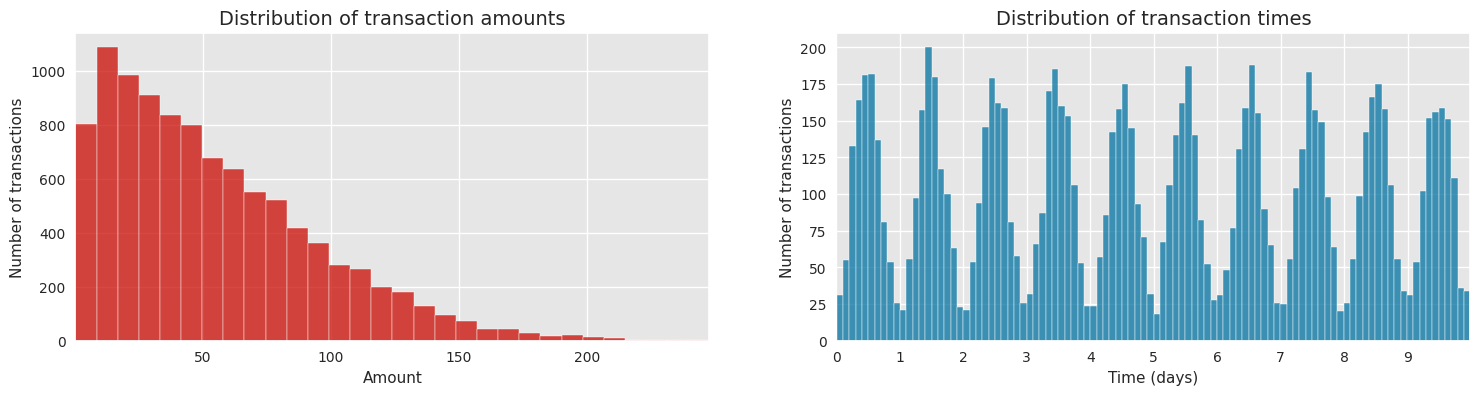

In [ ]:
# Gráficas de distribución de tiempo y cantidad de las transacciones
distribution_amount_times_fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = transactions_df[transactions_df.TX_TIME_DAYS < 10]['TX_AMOUNT'].sample(n=10000).values
time_val = transactions_df[transactions_df.TX_TIME_DAYS < 10]['TX_TIME_SECONDS'].sample(n=10000).values

sns.histplot(amount_val, ax=ax[0], color='r', bins=30, kde=False)
ax[0].set_title('Distribution of transaction amounts', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])
ax[0].set(xlabel="Amount", ylabel="Number of transactions")

sns.histplot(time_val / 86400, ax=ax[1], color='b', bins=100, kde=False)
ax[1].set_title('Distribution of transaction times', fontsize=14)
ax[1].set_xlim([min(time_val / 86400), max(time_val / 86400)])
ax[1].set_xticks(range(10))
ax[1].set(xlabel="Time (days)", ylabel="Number of transactions")

plt.show()

In [ ]:
# Selección aleatoria de víctimas de fraude
carding_victim = np.random.choice(customer_ids, size=int(0.12*len(customer_ids)))

In [ ]:
# Generación de etiquetas

transactions_df['CARDING'] = 0

for customer_id in carding_victim:
    carding_tx_idxs = np.random.choice(transactions_df[transactions_df['CUSTOMER_ID'] == customer_id].index, size=4, replace=False)
    transactions_df.loc[carding_tx_idxs, 'TX_AMOUNT'] = [generate_fraud_transaction() for _ in range(4)]
    transactions_df.loc[carding_tx_idxs, 'CARDING'] = 1

In [ ]:
# Cantidad de transacciones por clase
conteo_clases = transactions_df['CARDING'].value_counts()
porcentaje_clase = (conteo_clases / conteo_clases.sum()) * 100
conteo_clases

0    2604177
1       1440
Name: CARDING, dtype: int64

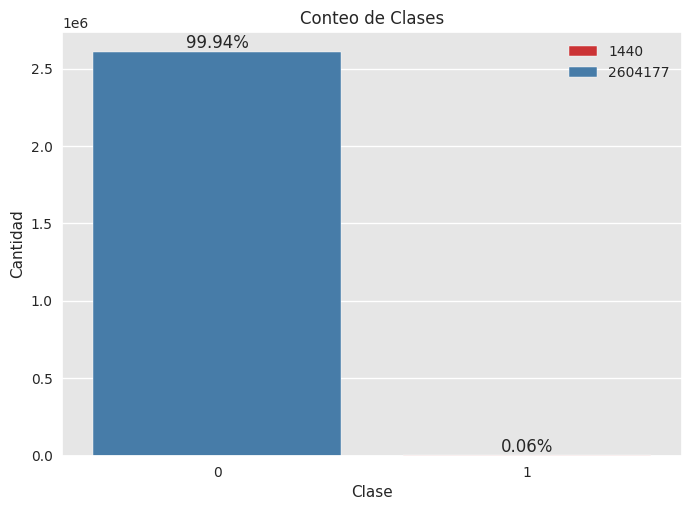

In [ ]:
sns.barplot(x=conteo_clases.index, y=conteo_clases.values, hue=conteo_clases.values ,palette='Set1')
plt.title('Conteo de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
for i, valor in enumerate(porcentaje_clase):
    plt.text(i, conteo_clases[i] + 0.1, f'{valor:.2f}%', ha='center', va='bottom')

In [ ]:
# Guardar lo hecho

DIR_OUTPUT_DRIVE = "/ruta/"

start_date = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")

for day in range(transactions_df.TX_TIME_DAYS.max()+1):
    transactions_day = transactions_df[transactions_df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT_DRIVE + filename_output, protocol=4)

# **Preprocessing** ⭐

In [ ]:
# Cargar lo hecho

DIR_OUTPUT_DRIVE = "/ruta/"

loaded_dataframes = []

for filename in os.listdir(DIR_OUTPUT_DRIVE):
    if filename.endswith(".pkl"):
        filepath = os.path.join(DIR_OUTPUT_DRIVE, filename)
        # Leer el archivo .pkl y añadirlo a la lista
        loaded_dataframes.append(pd.read_pickle(filepath))

df = pd.concat(loaded_dataframes, ignore_index=True)
df

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,WEB_ID,CATEGORY,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,CARDING
0,0,2023-01-01 00:00:11,1211.0,89,4,44.14,11,0,0
1,1,2023-01-01 00:00:30,356.0,83,2,75.92,30,0,0
2,2,2023-01-01 00:02:51,475.0,8,1,26.04,171,0,0
3,3,2023-01-01 00:03:12,53.0,27,2,51.89,192,0,0
4,4,2023-01-01 00:07:56,2.0,7,7,82.36,476,0,0
...,...,...,...,...,...,...,...,...,...
2605612,2605612,2023-10-27 23:56:04,2554.0,3,0,79.27,25919764,299,0
2605613,2605613,2023-10-27 23:57:58,767.0,12,0,66.76,25919878,299,0
2605614,2605614,2023-10-27 23:58:37,2180.0,57,3,27.52,25919917,299,0
2605615,2605615,2023-10-27 23:59:13,2695.0,39,0,86.43,25919953,299,0


In [ ]:
def is_weekend(tx_datetime):
    """
    Determina si una fecha dada cae en un fin de semana.
    """
    # Transform date into weekday (0 is Monday, 6 is Sunday)
    weekday = tx_datetime.weekday()
    # Binary value: 0 if weekday, 1 if weekend
    is_weekend = weekday>=5

    return int(is_weekend)

In [ ]:
%time df['TX_DURING_WEEKEND'] = df.TX_DATETIME.apply(is_weekend)
df

CPU times: user 9.8 s, sys: 1.79 s, total: 11.6 s
Wall time: 13.2 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,WEB_ID,CATEGORY,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,CARDING,TX_DURING_WEEKEND
0,0,2023-01-01 00:00:11,1211.0,89,4,44.14,11,0,0,1
1,1,2023-01-01 00:00:30,356.0,83,2,75.92,30,0,0,1
2,2,2023-01-01 00:02:51,475.0,8,1,26.04,171,0,0,1
3,3,2023-01-01 00:03:12,53.0,27,2,51.89,192,0,0,1
4,4,2023-01-01 00:07:56,2.0,7,7,82.36,476,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2605612,2605612,2023-10-27 23:56:04,2554.0,3,0,79.27,25919764,299,0,0
2605613,2605613,2023-10-27 23:57:58,767.0,12,0,66.76,25919878,299,0,0
2605614,2605614,2023-10-27 23:58:37,2180.0,57,3,27.52,25919917,299,0,0
2605615,2605615,2023-10-27 23:59:13,2695.0,39,0,86.43,25919953,299,0,0


In [ ]:
def is_night(tx_datetime):
    """
    Determina si la transacción fue hecha o no en la noche
    """
    # Get the hour of the transaction
    tx_hour = tx_datetime.hour
    # Binary value: 1 if hour less than 6, and 0 otherwise
    is_night = tx_hour<=6

    return int(is_night)

In [ ]:
%time df['TX_DURING_NIGHT'] = df.TX_DATETIME.apply(is_night)
df

CPU times: user 5.09 s, sys: 666 ms, total: 5.75 s
Wall time: 5.73 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,WEB_ID,CATEGORY,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,CARDING,TX_DURING_WEEKEND,TX_DURING_NIGHT
0,0,2023-01-01 00:00:11,1211.0,89,4,44.14,11,0,0,1,1
1,1,2023-01-01 00:00:30,356.0,83,2,75.92,30,0,0,1,1
2,2,2023-01-01 00:02:51,475.0,8,1,26.04,171,0,0,1,1
3,3,2023-01-01 00:03:12,53.0,27,2,51.89,192,0,0,1,1
4,4,2023-01-01 00:07:56,2.0,7,7,82.36,476,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2605612,2605612,2023-10-27 23:56:04,2554.0,3,0,79.27,25919764,299,0,0,0
2605613,2605613,2023-10-27 23:57:58,767.0,12,0,66.76,25919878,299,0,0,0
2605614,2605614,2023-10-27 23:58:37,2180.0,57,3,27.52,25919917,299,0,0,0
2605615,2605615,2023-10-27 23:59:13,2695.0,39,0,86.43,25919953,299,0,0,0


In [ ]:
def get_customer_spending_behaviour_features(customer_transactions, windows_size_in_days=[1,7,30]):
    """
    Calcula características relacionadas con el comportamiento de gasto del cliente.

    Args:
    customer_transactions (DataFrame): Tabla de transacciones del cliente.
    windows_size_in_days (list): Lista de tamaños de ventana en días para calcular características. Por defecto: [1, 7, 30].

    Returns:
    DataFrame: Tabla de transacciones del cliente con características agregadas.
    """
    # Let us first order transactions chronologically
    customer_transactions=customer_transactions.sort_values('TX_DATETIME')

    # The transaction date and time is set as the index, which will allow the use of the rolling function
    customer_transactions.index=customer_transactions.TX_DATETIME

    # For each window size
    for window_size in windows_size_in_days:

        # Compute the sum of the transaction amounts and the number of transactions for the given window size
        SUM_AMOUNT_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').sum()
        NB_TX_WINDOW=customer_transactions['TX_AMOUNT'].rolling(str(window_size)+'d').count()

        # Compute the average transaction amount for the given window size
        # NB_TX_WINDOW is always >0 since current transaction is always included
        AVG_AMOUNT_TX_WINDOW=SUM_AMOUNT_TX_WINDOW/NB_TX_WINDOW

        # Save feature values
        customer_transactions['CUSTOMER_ID_NB_TX_'+str(window_size)+'DAY_WINDOW']=list(NB_TX_WINDOW)
        customer_transactions['CUSTOMER_ID_AVG_AMOUNT_'+str(window_size)+'DAY_WINDOW']=list(AVG_AMOUNT_TX_WINDOW)

    # Reindex according to transaction IDs
    customer_transactions.index=customer_transactions.TRANSACTION_ID

    # And return the dataframe with the new features
    return customer_transactions

In [ ]:
%time df = df.groupby('CUSTOMER_ID').apply(lambda x: get_customer_spending_behaviour_features(x, windows_size_in_days=[1,7,30]))
df = df.sort_values('TX_DATETIME').reset_index(drop=True)
df

CPU times: user 31.1 s, sys: 1.31 s, total: 32.4 s
Wall time: 33.3 s


,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,WEB_ID,CATEGORY,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,CARDING,TX_DURING_WEEKEND,TX_DURING_NIGHT,CUSTOMER_ID_NB_TX_1DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW
0,0,2023-01-01 00:00:11,1211.0,89,4,44.14,11,0,0,1,1,1.0,44.140000,1.0,44.140000,1.0,44.140000
1,1,2023-01-01 00:00:30,356.0,83,2,75.92,30,0,0,1,1,1.0,75.920000,1.0,75.920000,1.0,75.920000
2,2,2023-01-01 00:02:51,475.0,8,1,26.04,171,0,0,1,1,1.0,26.040000,1.0,26.040000,1.0,26.040000
3,3,2023-01-01 00:03:12,53.0,27,2,51.89,192,0,0,1,1,1.0,51.890000,1.0,51.890000,1.0,51.890000
4,4,2023-01-01 00:07:56,2.0,7,7,82.36,476,0,0,1,1,1.0,82.360000,1.0,82.360000,1.0,82.360000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2605612,2605612,2023-10-27 23:56:04,2554.0,3,0,79.27,25919764,299,0,0,0,5.0,61.890000,33.0,54.802727,153.0,61.061438
2605613,2605613,2023-10-27 23:57:58,767.0,12,0,66.76,25919878,299,0,0,0,2.0,61.695000,23.0,53.241304,111.0,52.145766
2605614,2605614,2023-10-27 23:58:37,2180.0,57,3,27.52,25919917,299,0,0,0,3.0,29.933333,9.0,31.466667,53.0,30.950189
2605615,2605615,2023-10-27 23:59:13,2695.0,39,0,86.43,25919953,299,0,0,0,3.0,153.916667,20.0,112.236500,78.0,105.586410


In [ ]:
# Guardar lo hecho

DIR_OUTPUT_DRIVE = "/ruta/"

start_date = datetime.datetime.strptime("2023-01-01", "%Y-%m-%d")

for day in range(df.TX_TIME_DAYS.max()+1):
    transactions_day = df[df.TX_TIME_DAYS==day].sort_values('TX_TIME_SECONDS')
    date = start_date + datetime.timedelta(days=day)
    filename_output = date.strftime("%Y-%m-%d")+'.pkl'
    # Protocol=4 required for Google Colab
    transactions_day.to_pickle(DIR_OUTPUT_DRIVE + filename_output, protocol=4)

In [ ]:
# Guardar csv

file_path = 'carding.csv'

# Save the DataFrame to a CSV file
df.to_csv(file_path, index=False)

# Download the CSV file to your local machine
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>